In [ ]:
!pip install keras-tuner

In [ ]:
#!pip install -U scikit-image[optional]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Tensorflow and Keras libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
import keras_tuner as kt
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Sklearn libraries
from sklearn.metrics import classification_report

#Skimage packages
import skimage
from skimage.io import imread

#Other packages
import os
import sys
import pathlib
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings  
warnings.filterwarnings('ignore')


## 1. Introduction

Malaria is a disease caused by a parasite called Plasmodium falciparum that spreads to humans through the bites of infected mosquitoes. The disease is prevalent in many countries, especially in tropical regions, and causes significant mortality, killing about 400,000-600,000 people yearly [1].
Parasites carried by mosquito bites get into the bloodstream and infect oxygen-carrying red blood cells (RBCs). Typically, the symptoms are similar to the flu, but parasites can stay in RBCs for months, causing severe complications and even death. Therefore, early diagnosis and treatment are crucial to reducing mortality.

The disease is diagnosed using blood smears, an intensive manual process requiring trained professionals to classify and count parasitized and uninfected cells. This project aims to develop deep learning (DL) models, specifically Convolutional Neural Networks (CNNs), to apply computer vision techniques for malaria diagnosis.

A dataset used in this project was collected by the US National Institutes of Health and is also available from the Kaggle website [2,3]. The dataset contains 27,558  images of red blood cells from 150 patients infected by the parasite and mixed with cell images from 50 healthy patients.
Objectives of the project.

Image preprocessing and creating datasets suitable for DL models to classify whether the detected cell is infected or uninfected by the parasite.
Develop a feedforward neural network (NN) as a baseline model.
Develop and tune CNN models for the computer vision task.
Apply transfer learning using pre-trained NN models.

## 2. Image preprocessing

### 2.1. Load and visualise images

The zipped dataset was downloaded from the Kaggle website, and upon unzipping, two folders were created corresponding to images of uninfected and parasitized cells, respectively. As the task is a binary classification, the images were assigned to either 0 (uninfected) or 1 (parasitized) classes.

The images were loaded off the disk, and corresponding labels were obtained.

In [ ]:
# Image directory
img_loc = '/content/drive/MyDrive/Colab Notebooks/MSc at UoL/DSM150_Neural_Networks/CW2/data/'
img_loc = pathlib.Path(img_loc)

In [ ]:
# To confirm the correct number of images
image_count = len(list(img_loc.glob('*/*.png')))
print(image_count)

27558


In [ ]:
#Get image categories/labels
labels = os.listdir(img_loc)
labels

['0. Uninfected', '1. Parasitized']

In [ ]:
#Print the fist image file names for each category
uninfected = list(img_loc.glob('0. Uninfected/*'))
parasitized = list(img_loc.glob('1. Parasitized/*'))
print(uninfected[0])
print(parasitized[0])

/content/drive/MyDrive/Colab Notebooks/MSc at UoL/DSM150_Neural_Networks/CW2/data/0. Uninfected/C79P40ThinF_IMG_20150817_103303_cell_87.png
/content/drive/MyDrive/Colab Notebooks/MSc at UoL/DSM150_Neural_Networks/CW2/data/1. Parasitized/C99P60ThinF_IMG_20150918_141520_cell_136.png


In [ ]:
print('Number of infected cells: ',len(parasitized))
print('Number of uninfected cells: ',len(uninfected))

Number of infected cells:  13779
Number of uninfected cells:  13779


Counting the images confirmed that the dataset is balanced, containing an equal number of images of both classes.

To visualise blood cell images, matplotlib library is used to plot the images by iterating through the dataset and taking the first four instances (rows) of cells.

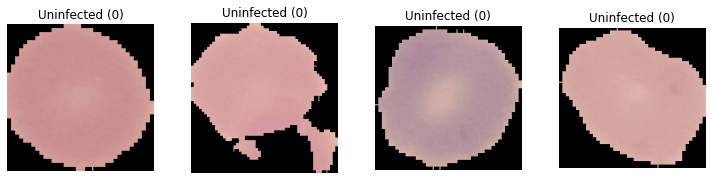

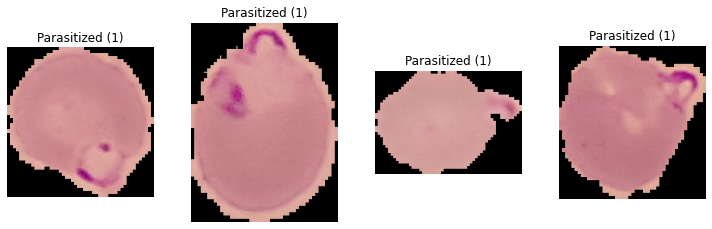

In [ ]:
plt.figure(figsize = (10,20))
for i in range(4):
    plt.subplot(1, 4, i+1)
    image = PIL.Image.open(str(uninfected[i]))
    plt.imshow(image)
    plt.title('Uninfected (0)')
    plt.tight_layout()
    plt.axis('off')
plt.show()
plt.figure(figsize = (10,20))
for i in range(4):
    plt.subplot(1, 4, i+1)
    image = PIL.Image.open(str(parasitized[i]))
    plt.imshow(image)
    plt.title('Parasitized (1)')
    plt.tight_layout()
    plt.axis('off')
plt.show()

### 2.2. Create training and testing datasets


####2.2.1. Split images into train, validation and test datasets.

Split-folders library was used to split the dataset into training, validation and testing folders [4]

In [ ]:
pip install split-folders

In [ ]:
import splitfolders

In [ ]:
# Paths to input and output folders
input_folder = "/content/drive/MyDrive/Colab Notebooks/MSc at UoL/DSM150_Neural_Networks/CW2/data/"
output = "/content/drive/MyDrive/Colab Notebooks/MSc at UoL/DSM150_Neural_Networks/CW2/images/" 

# Split into train and testing sets
splitfolders.ratio(input_folder, output=output, seed=11, ratio=(.8, .2)) 

In [ ]:
#Path to train and test datasets
dir_train = "/content/drive/MyDrive/Colab Notebooks/MSc at UoL/DSM150_Neural_Networks/CW2/images/train/" 
dir_train = pathlib.Path(dir_train)
dir_test = "/content/drive/MyDrive/Colab Notebooks/MSc at UoL/DSM150_Neural_Networks/CW2/images/val/" 
dir_test = pathlib.Path(dir_test)

#### 2.2.2 Generate tf.data.Datasets from image files in a directory.

According to the Keras documentation, "calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b)" [5].
It also allows resizing images and assigning validation sets.

Images were resized to have 100 x 100-pixel dimensions with 256 images per batch using the codes below [6].

In [ ]:
# Parameters for the loader
batch_size = 256
img_height = 100
img_width = 100

In [ ]:
# Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  dir_train,
  labels = "inferred",
  label_mode = "binary",
  shuffle=True,
  validation_split=0.2,
  subset="training",
  seed=12,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 22046 files belonging to 2 classes.
Using 17637 files for training.


In [ ]:
# validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  dir_train,
  labels = "inferred",
  label_mode = "binary",
  shuffle=True,
  validation_split=0.2,
  subset="validation",
  seed=12,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 22046 files belonging to 2 classes.
Using 4409 files for validation.


In [ ]:
# Testing dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
  dir_test,
  labels = "inferred",
  label_mode = "binary",
  validation_split=None,
  subset=None,
  shuffle=True,
  seed=12,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5512 files belonging to 2 classes.


Thre datasets contain 17637, 4409 and 5512 images for training, validation and testing purposes.

In [ ]:
# Print class labels 
class_names = train_ds.class_names
print(class_names)

['0. Uninfected', '1. Parasitized']


In [ ]:
# Print shape of images and labels [6]
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(256, 100, 100, 3)
(256, 1)


The image_batch is a tensor of the shape (256, 100, 100, 3). This is a batch of 256 images of shape 180x180x3, with the last dimension referring to colour channels (RGB). The label_batch is a tensor of the shape (256,1), the corresponding labels to the 256 images.

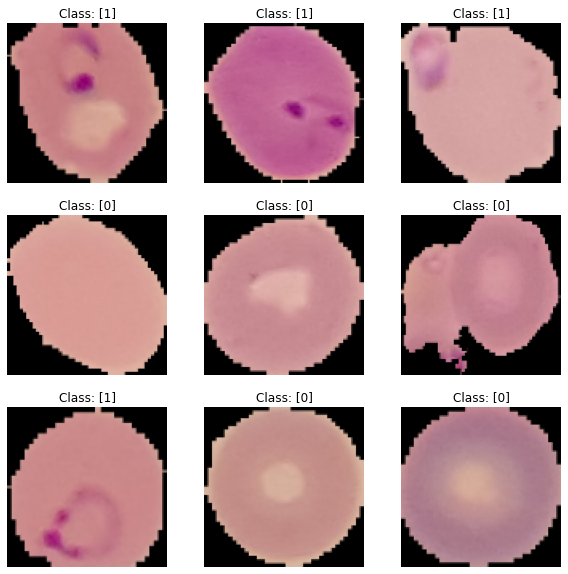

In [ ]:
#Plot images to verify that split datasets have correctly labelled images.
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1): # take the first batch  and plot 9 images
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f'Class: {(labels[i]).numpy().astype(int)}')
    plt.axis("off")

#### 2.2.3 Image rescalling

In [ ]:
# Function for rescaling images to have pixel values from 0 to 1 (code adopted from [6])
def normalize(ds):
    normalization_layer = layers.Rescaling(1./255)
    normalized_ds = ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    #print min and max values of the 1st image
    first_image = image_batch[0]
    print(f'min: {np.min(first_image)}, max: {np.max(first_image)}')
    return ds

In [ ]:
#Rescale the datasets
train_ds = normalize(train_ds)
val_ds = normalize(val_ds)
test_ds = normalize(test_ds)

min: 0.0, max: 0.8936078548431396
min: 0.0, max: 0.8653926253318787
min: 0.0, max: 0.9094363451004028


#### 2.2.4. Configure the dataset for performance

As the image datasets are large, Dataset.cache was used to keep the images in memory after loading them off disk during the first epoch. This ensures that the dataset does not become a bottleneck while training models [6]. 

Dataset.prefetch overlaps data preprocessing and model execution while training [6]. tf.data.AUTOTUNE allows dynamic tuning of the number of prefetched elements at runtime [7]. Both methods, when used together, allow yielding data from disk without having I/O become blocking [6,7].

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 3. Training models

#### 3.1.1 Create a feedforward neural network

Initially, a feedforward neural network was created with three densely connected hidden layers. The hidden layers were initiated using the relu activation function, while the sigmoid function was applied at the output layer. The hidden layer's size is set randomly to test if the model can achieve some predictive power. For this binary classification task, 'binary_crossentropy' was selected as the loss function. Adam optimiser with a default learning rate was used for learning model weights during backpropagation. Furthermore, L2 regularisation is applied to reduce model overfitting and improve generalisation.

The code below was adopted from Chollet (2021, p215)[8].

In [ ]:
def dense_model(unit1,unit2,unit3, optimizer, epochs):
    
    # fix random seed for reproducibility
    tf.random.set_seed(11)
    
    #Define input tensor - model expects grayscale image of size 100x100
    inputs = layers.Input(shape=(img_height, img_width, 3))

    # Create layers and pass to input tensor
    x = layers.Flatten()(inputs)
    x = layers.Dense(unit1, kernel_regularizer=regularizers.l2(0.002), activation='relu')(x)
    x = layers.Dense(unit2, kernel_regularizer=regularizers.l2(0.002),activation='relu')(x)
    x = layers.Dense(unit3, kernel_regularizer=regularizers.l2(0.002),activation='relu')(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, output)

    #callback to save the model after each epoch
    callbacks = [ModelCheckpoint(filepath="dens.keras", save_best_only=True,monitor="val_loss")]

    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizer,
                  metrics=['acc'])
    #print model's summary         
    model.summary()
    
    history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks = callbacks)
    
    return model, history

#### 3.1.2.Train and evaluate a feedforward model

In [ ]:
dense_model, dense_history = dense_model(unit1=250,unit2=150,unit3=30, optimizer='adam', epochs = 30)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 flatten_8 (Flatten)         (None, 30000)             0         
                                                                 
 dense_24 (Dense)            (None, 250)               7500250   
                                                                 
 dense_25 (Dense)            (None, 150)               37650     
                                                                 
 dense_26 (Dense)            (None, 30)                4530      
                                                                 
 dense_27 (Dense)            (None, 1)                 31        
                                                                 
Total params: 7,542,461
Trainable params: 7,542,461
Non-tra

#### 3.1.3.Plotting the training and validation loss and metrics

---



In [ ]:
# function to plot training and validation metrics
def plot_metrics(model, history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
  
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
  
    epochs = range(1, len(train_loss)+1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1.plot(epochs, train_loss, '-r', label = 'Training loss')
    ax1.plot(epochs, val_loss, '-b', label = 'Validation loss')
    ax1.set_xlabel("epochs")
    ax1.set_ylabel(('Loss'))
    ax1.set_title(f'Training and Validation loss of {model}')
    ax1.legend()

    ax2.plot(epochs, train_acc, '-r', label = 'Training accuracy')
    ax2.plot(epochs, val_acc, '-b', label = 'Validation accuracy')
    ax2.set_xlabel("epochs")
    ax2.set_ylabel(('Accuracy'))
    ax2.set_title(f'Training and Validation accuracy of {model}')
    ax2.legend()
  
    plt.show()
    return

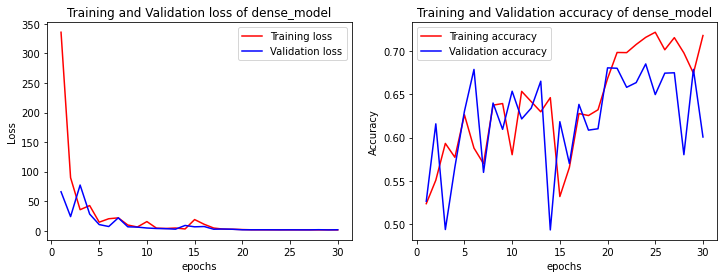

In [ ]:
plot_metrics(model = 'dense_model', history = dense_history)

In [ ]:
model = keras.models.load_model("dens.keras")
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc*100:.2f}%')

22/22 [==============================] - 5s 138ms/step - loss: 1.4865 - acc: 0.6845
Test accuracy: 68.45%


Plots show that training and validation losses decrease and stall without further improvement over 30 epochs. Test and validation accuracies reach 72% and 68%, respectively; however, the model's performance is not very stable, with considerable variations in validation accuracy. These data suggest that a dense feedforward model can learn, beating the baseline prediction of a random binary classifier (50%). 

Evaluation of the test subset revealed that the base model has an accuracy of 68%. Further optimization of hyperparameters, i.e. choice of optimizers and their learning rate, the number of hidden layers, batch size and epochs, may further increase the model's accuracy.

## 3.2.Convolutional neural networks (CNN)

#### 3.2.1. Baseline CNN network

In [ ]:
def cnn_base_model(filters1, optimizer, epochs):
    ''' This function is for base covolutional model with 
    one Conv2D and MaxPolling2D layers
    '''
    # fix random seed for reproducibility
    tf.random.set_seed(11)
    
    #Define input tensor - model expects grayscale image of size 100x100
    inputs = layers.Input(shape=(img_height, img_width,3))

    # Create layers and pass to input tensor
    x = layers.Conv2D(filters1, kernel_size=3, activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    
    # Flatten and set one hidden dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(20, kernel_regularizer=regularizers.l2(0.002), activation='relu')(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, output)

    #callback to save the model after each epoch
    callbacks = [ModelCheckpoint(filepath="cnn_base.keras", save_best_only=True,monitor="val_loss")]

    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizer,
                  metrics=['acc'])
    #print model's summary         
    model.summary()
    
    history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks = callbacks)
    
    return model, history

In [ ]:
cnn_base_model, cnn_base_history = cnn_base_model(filters1=256, optimizer='adam', epochs = 15)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 98, 98, 256)       7168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 49, 49, 256)      0         
 2D)                                                             
                                                                 
 flatten_10 (Flatten)        (None, 614656)            0         
                                                                 
 dense_30 (Dense)            (None, 20)                12293140  
                                                                 
 dense_31 (Dense)            (None, 1)                 21        
                                                           

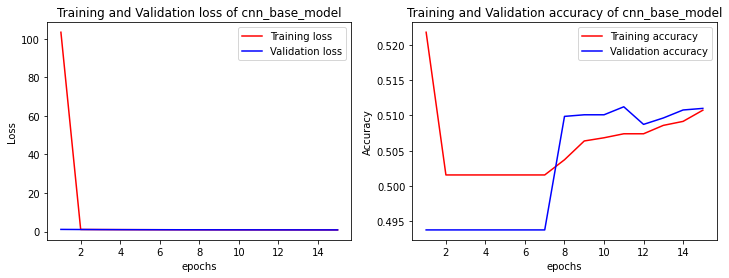

In [ ]:
plot_metrics(model = 'cnn_base_model', history = cnn_base_history)

In [ ]:
model = keras.models.load_model("cnn_base.keras")
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc*100:.2f}%')

22/22 [==============================] - 5s 235ms/step - loss: 0.9176 - acc: 0.8217
Test accuracy: 82.17%


The base CNN model can obtain 91% and 89% accuracy on the training and validation datasets, a significant improvement compared to the dense feedforward model. 

Validation and training losses continue to decrease, stall, and then increase after epochs 7. This suggests that the base CNN model with one convolutional layer performs better than the feedforward model with three hidden layers; however, the model may need to be more complex to learn and generalise on unseen datasets. Two additional Conv2D hidden layers were added to address these issues to increase the model's capacity.

#### 3.2.2. Increasing capacity of the CNN model

Two additional Conv2D layers were used with the MaxPooling2D layer after each Conv2D to increase model complexity. Furthermore, two hidden dense layers were also added. A Dropout layer was also added after each convolution layer to reduce overfitting.

In [ ]:
def cnn2_model(filters1,filters2, filters3, optimizer, epochs, batch_size):
    # fix random seed for reproducibility
    tf.random.set_seed(11)
    
    #Define input tensor - model expects grayscale image of size 100x100
    inputs = layers.Input(shape=(img_height, img_width, 3))

    # Create layers and pass to input tensor
    x = layers.Conv2D(filters1, kernel_size=3, activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(filters2, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(filters3, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)
   
    # Dense layers
    x = layers.Flatten()(x) 
    x = layers.Dense(300, kernel_regularizer=regularizers.l2(0.002),activation='relu')(x)
    x = layers.Dense(100,kernel_regularizer=regularizers.l2(0.002),activation='relu')(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    x = layers.Dropout(0.2)(x)

    model = keras.Model(inputs, output)

    #callback to save the model after each epoch
    callbacks = [ModelCheckpoint(filepath="cnn2.keras", save_best_only=True,monitor="val_loss")]
    
    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizer,
                  metrics=['acc'])
    #print model's summary         
    model.summary()
    
    history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks = callbacks)
    
    return model, history

In [ ]:
cnn2_model, cnn2_history = cnn2_model(filters1=64, filters2=128, filters3 = 256, optimizer='adam', epochs = 15,batch_size = 256)

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_19 (Conv2D)          (None, 98, 98, 64)        1792      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 49, 49, 64)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 47, 47, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 23, 23, 128)      0         
 g2D)                                                     

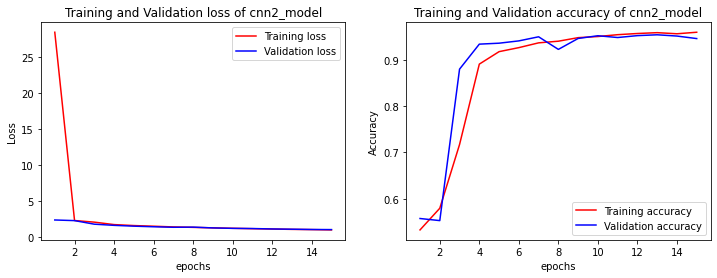

In [ ]:
plot_metrics(model = 'cnn2_model', history = cnn2_history)

In [ ]:
model2 = keras.models.load_model("cnn2.keras")
test_loss, test_acc = model2.evaluate(test_ds)
print(f'Test accuracy: {test_acc*100:.2f}%')

22/22 [==============================] - 5s 210ms/step - loss: 1.0214 - acc: 0.9497
Test accuracy: 94.97%


Three convolutional layers have significantly improved the model's performance over the base CNN model, with training accuracy reaching over 96% and validation accuracy peaking at 95%. In contrast, training and validation losses are almost identical. Similarly, the model's accuracy on test samples also increased to 95%.

Next, hyperparameter tuning was performed to test if the model's performance could be increased further. 
Hyperparameter tuning was performed using the KerasTuner library.

## 4 CNN: hyperparameter tuning

#### 4.1.1. Define the search space
KerasTuner is a general-purpose hyperparameter tuning library. At this stage, only the filter size in each hidden convolutional layer was tuned by defining an integer hyperparameter with hp.Int(). Other hyperparameters can also be tuned, such as using a Dropout layer with hp.Boolean(), tuning activation functions using hp.Choice(), tuning the learning rate of the optimizer with hp.Float() [9].



In [ ]:
# Function to create model, required for KerasClassifier
def build_model(hp):
    '''
    This function returns a compiled Keras model. It takes an argument hp for defining 
    the hyperparameters while building the model.
    '''
    # fix random seed for reproducibility
    tf.random.set_seed(11)
    
    #Define input tensor - model expects grayscale image of size 128x128
    inputs = layers.Input(shape=(img_height, img_width, 3)) 
    
    # Create layers and pass to input tensor
    x = layers.Conv2D(filters = hp.Int('conv_1_filter', min_value=32, max_value=64, step=32), kernel_size=3, activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.2)(x)     
    
    x = layers.Conv2D(filters = hp.Int('conv_2_filter', min_value=64, max_value=128, step=64), kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.2)(x)      
    
    x = layers.Conv2D(filters = hp.Int('conv_3_filter', min_value=128, max_value=256, step=128), kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.2)(x)    
   
    # Dense layers
    x = layers.Flatten()(x) 
    x = layers.Dense(300,kernel_regularizer=regularizers.l2(0.002),activation='relu')(x)
    x = layers.Dense(100,kernel_regularizer=regularizers.l2(0.002),activation='relu')(x)

    output = layers.Dense(1, activation='sigmoid')(x)

    # initialize the learning rate choices and optimizer
    #lr = hp.Choice("learning_rate", values=[1e-2, 1e-3])
    #opt = Adam(learning_rate=lr)
    
    model = keras.Model(inputs, output)
    model.compile(loss = 'binary_crossentropy',
                  optimizer = "adam",
                  metrics=['accuracy'])
    return model

In [ ]:
# instantiate the random search tuner object
tuner_rs = RandomSearch(
        build_model,
        objective="val_accuracy",
        seed=42,
        directory = 'output', 
        project_name = 'malaria',
        max_trials=20)

In [ ]:
# perform the hyperparameter search
tuner_rs.search(
    train_ds,
    validation_data = val_ds,
    epochs=5)

Trial 7 Complete [00h 02m 03s]
val_accuracy: 0.630528450012207

Best val_accuracy So Far: 0.9276480078697205
Total elapsed time: 00h 13m 17s
INFO:tensorflow:Oracle triggered exit


In [ ]:
#summary of the search results
tuner_rs.results_summary()

Results summary
Results in output/malaria
Showing 10 best trials
Trial summary
Hyperparameters:
conv_1_filter: 64
conv_2_filter: 64
conv_3_filter: 256
Score: 0.9276480078697205
Trial summary
Hyperparameters:
conv_1_filter: 64
conv_2_filter: 64
conv_3_filter: 128
Score: 0.9240190386772156
Trial summary
Hyperparameters:
conv_1_filter: 32
conv_2_filter: 64
conv_3_filter: 128
Score: 0.9131322503089905
Trial summary
Hyperparameters:
conv_1_filter: 32
conv_2_filter: 128
conv_3_filter: 128
Score: 0.8949875235557556
Trial summary
Hyperparameters:
conv_1_filter: 32
conv_2_filter: 64
conv_3_filter: 256
Score: 0.834202766418457
Trial summary
Hyperparameters:
conv_1_filter: 64
conv_2_filter: 128
conv_3_filter: 128
Score: 0.630528450012207
Trial summary
Hyperparameters:
conv_1_filter: 32
conv_2_filter: 128
conv_3_filter: 256
Score: 0.6148786544799805


In [ ]:
# grab the best hyperparameters
bestHP_rs = tuner_rs.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal number of filters in conv_1 layer: {bestHP_rs.get('conv_1_filter')}")
print(f"Optimal number of filters in conv_2 layer: {bestHP_rs.get('conv_2_filter')}")
print(f"Optimal number of filters in conv_2 layer: {bestHP_rs.get('conv_3_filter')}")
#print(f"Optimal learning rate: {bestHP_rs.get('learning_rate'):.3f}")

Optimal number of filters in conv_1 layer: 64
Optimal number of filters in conv_2 layer: 64
Optimal number of filters in conv_2 layer: 256


In [ ]:
# Use the best model and train it further
model = tuner_rs.get_best_models(num_models=1)[0]
model.fit(train_ds,
          validation_data = val_ds,
          epochs=20,
          initial_epoch= 5, # as the model was trained using 5 epochs
          verbose=1)

Epoch 6/20
69/69 [==============================] - 22s 290ms/step - loss: 1.4770 - accuracy: 0.9300 - val_loss: 1.5645 - val_accuracy: 0.8766
Epoch 7/20
69/69 [==============================] - 23s 312ms/step - loss: 1.3922 - accuracy: 0.9350 - val_loss: 1.3801 - val_accuracy: 0.9422
Epoch 8/20
69/69 [==============================] - 21s 281ms/step - loss: 1.3131 - accuracy: 0.9409 - val_loss: 1.3494 - val_accuracy: 0.9297
Epoch 9/20
69/69 [==============================] - 21s 282ms/step - loss: 1.2448 - accuracy: 0.9449 - val_loss: 1.2406 - val_accuracy: 0.9435
Epoch 10/20
69/69 [==============================] - 21s 285ms/step - loss: 1.1766 - accuracy: 0.9495 - val_loss: 1.1946 - val_accuracy: 0.9415
Epoch 11/20
69/69 [==============================] - 21s 284ms/step - loss: 1.1227 - accuracy: 0.9510 - val_loss: 1.1187 - val_accuracy: 0.9499
Epoch 12/20
69/69 [==============================] - 21s 283ms/step - loss: 1.0756 - accuracy: 0.9533 - val_loss: 1.0975 - val_accuracy: 0.9

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc*100:.2f}%')

22/22 [==============================] - 5s 229ms/step - loss: 0.8065 - accuracy: 0.9554
Test accuracy: 95.54%


Hyperparameter tuning slightly improved accuracy on testing dataset. 

## 5 Transfer learning

#### 5.1.1. Ussing the VGG16 pretrained model for malaria image classification

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

VGG16 network was trained on the ImageNet dataset, containing more than 14 million high-resolution images belonging to 1000 different labels [10].

While the VGG16 network was not trained to classify malaria-infected cells, it can extract important features and help achieve good results with less expensive computation [11].

In [ ]:
## Loading VGG16 model
vgg16_base_model = VGG16(weights="imagenet", include_top=False, input_shape=(100, 100, 3))
vgg16_base_model.trainable = False ## Not trainable weights

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16_base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

####5.1.2. Instantiating the VGG16 convolutional base

In [ ]:
def vgg16_base(filters1,filters2, filters3, optimizer, epochs,batch_size):
    tf.random.set_seed(11)

    data_augmentation = keras.Sequential(
        [layers.RandomFlip("horizontal"),
         layers.RandomRotation(0.1),
         layers.RandomZoom(0.2)])

    #Define input tensor - model expects grayscale image of size 125x125
    inputs = layers.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = keras.applications.vgg16.preprocess_input(x)    # Preprocessing input
    x = vgg16_base_model(x)
    x = layers.Flatten()(x) 
    x = layers.Dense(300)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100)(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)

    #callback to save the model after each epoch
    callbacks = [ModelCheckpoint(filepath="vgg16_base.keras", save_best_only=True,monitor="val_loss")]
    
    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizer,
                  metrics=['acc'])
    #print model's summary         
    model.summary()
    
    history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks = callbacks)
    
    return model, history

In [ ]:
vgg16_base_model, vgg16_base_history = vgg16_base(filters1=64, filters2=128, filters3 = 256, optimizer='adam', epochs = 15, batch_size = 256)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 tf.__operators__.getitem_5   (None, 100, 100, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 100, 100, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 4608)              0   

In [ ]:
vgg16_base = keras.models.load_model("vgg16_base.keras")
test_loss, test_acc = vgg16_base.evaluate(test_ds)
print(f'Test accuracy: {test_acc*100:.2f}%')

22/22 [==============================] - 11s 459ms/step - loss: 0.1708 - acc: 0.9425
Test accuracy: 94.25%


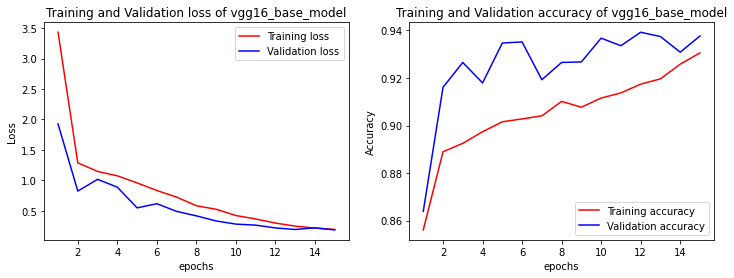

In [ ]:
plot_metrics(model = 'vgg16_base_model', history = vgg16_base_history)

Using the pre-trained base VGG16 model enabled a very similar accuracy (94%) as the model developed here from scratch, thus providing a significant benefit in reducing computational resources.

#### 5.1.3. Tuning VGG16 network

As the top layers of pre-trained models extract features particular to a particular dataset they were trained on, these layers are usually not helpful for classifying images unrelated to the original dataset. Therefore, the top layers of pre-trained models can be tuned by unfreezing them and keeping the bottom layers untrainable as they extract more generic features, such as shapes, texture, angel etc.[11].

In [ ]:
# Unfreezing the top layers while the bottom four remaining untrainable
vgg16_base_model.trainable = True
for layer in vgg16_base_model.layers[:-4]:
    layer.trainable = False

In [ ]:
vgg16_base_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 tf.__operators__.getitem_5   (None, 100, 100, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 100, 100, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 4608)              0   

In [ ]:
def vgg16_tuned(filters1,filters2, filters3, optimizer, epochs,batch_size):
    tf.random.set_seed(11)

    data_augmentation = keras.Sequential(
        [layers.RandomFlip("horizontal"),
         layers.RandomRotation(0.1),
         layers.RandomZoom(0.2)])

    #Define input tensor - model expects grayscale image of size 125x125
    inputs = layers.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = keras.applications.vgg16.preprocess_input(x)
    x = vgg16_base_model(x)
    x = layers.Flatten()(x) 
    x = layers.Dense(300,kernel_regularizer=regularizers.l2(0.002), activation= 'relu')(x)
    x = layers.Dense(100,kernel_regularizer=regularizers.l2(0.002), activation = 'relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    
    #callback to save the model after each epoch
    callbacks = [ModelCheckpoint(filepath="vgg16_tuned.keras", save_best_only=True,monitor="val_loss")]

    model.compile(loss = 'binary_crossentropy',
              optimizer = optimizer,
              metrics='acc')

    #print model's summary         
    model.summary()
    
    history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    batch_size = batch_size,
                    callbacks=callbacks)
    return model, history

In [ ]:
 vgg16_tuned_model,  vgg16_tunedhistory =  vgg16_tuned(filters1=64, filters2=128, filters3 = 256, optimizer='adam', epochs = 15, batch_size = 256)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 tf.__operators__.getitem_6   (None, 100, 100, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_6 (TFOpLambd  (None, 100, 100, 3)      0         
 a)                                                              
                                                                 
 model_5 (Functional)        (None, 1)                 16127589  
                                                                 
 flatten_7 (Flatten)         (None, 1)                 0   

In [ ]:
vgg16_tuned = keras.models.load_model("vgg16_tuned.keras")
test_loss, test_acc = vgg16_tuned.evaluate(test_ds)
print(f'Test accuracy: {test_acc*100:.2f}%')

22/22 [==============================] - 7s 316ms/step - loss: 0.2186 - acc: 0.9302
Test accuracy: 93.02%


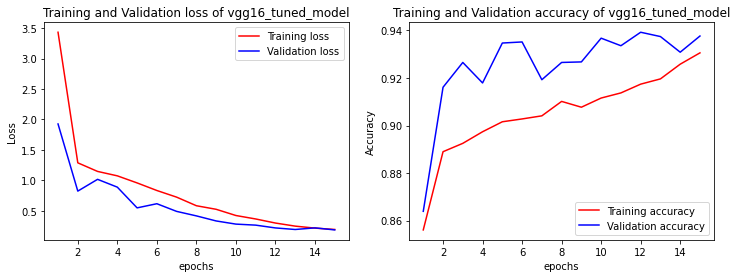

In [ ]:
plot_metrics(model = 'vgg16_tuned_model', history = vgg16_base_history)

Training the top layers of VGG16 network slightly reduced the model's performance, with accuracy on the testing dataset decreasing by 1%.

## 6.Model evaluation

To evaluate the model performance, a confusion matrix was created and other metrics, such as precision, recall and F1 score, were calculated.

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the test dataset
for image_batch, label_batch in test_ds:   
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model2.predict(image_batch)
   preds = (preds>0.5).astype(np.int32) # predictions with probability more than 0.5 are assigned to class 1
   # append predicted labels
   y_pred.append(preds)

# convert the true and predicted labels into tensors
correct_labels = np.concatenate([item for item in y_true], axis = 0).astype(np.int32)
predicted_labels = np.concatenate([item for item in y_pred], axis = 0)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion = confusion_matrix(correct_labels, predicted_labels)

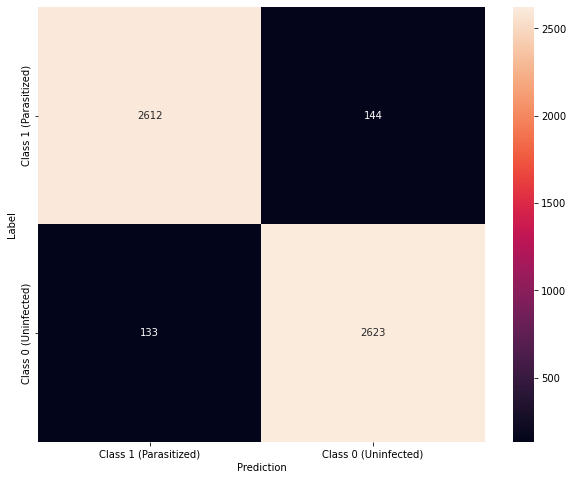

In [ ]:
  # plot confusion matrix
  class_labels = ['Class 1 (Parasitized)','Class 0 (Uninfected)']
  plt.figure(figsize=(10, 8))
  sns.heatmap(confusion, xticklabels=class_labels, yticklabels = class_labels, annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

In [ ]:
# Print evaluation metrics
print(classification_report(correct_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2756
           1       0.95      0.95      0.95      2756

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512



As the dataset is balanced, all evaluation metrics provide similar results with accuracy, precision, recall and F1 score being 95%.

## 7. Conclusion.

This project demonstrates that deep learning models can be successfully applied to detect malaria parasite-infected blood cells with a very high accuracy of 95%. Furthermore, the results also confirm that models using 2D convolutional layers outperform feedforward models for computer vision tasks.

## 8.  References
1. Malaria (https://www.cdc.gov/parasites/malaria/index.html)
2. Malaria Dataset (https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets)
3. Malaria Cell Images Dataset (https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria)
4. split-folders (https://pypi.org/project/split-folders/)
5. tf.keras.utils.image_dataset_from_directory (https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)
6. Load and preprocess images (https://www.tensorflow.org/tutorials/load_data/images).
7. Better performance with the tf.data API (https://www.tensorflow.org/guide/data_performance)
8. Chollet. Deep Learning with Pithon (2nd edition), 2021, Manning Publications
9. KerasTuner (https://keras.io/keras_tuner/)
10. Zhang, Xiangyu, et al. "Accelerating very deep convolutional networks for classification and detection." IEEE transactions on pattern analysis and machine intelligence 38.10 (2015): 1943-1955.
11. Transfer Learning with VGG16 and Keras (https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4)